# Content-Based Hotel Recommender System Based on Embeddings Optimised to Predict  Customer Purchasing Behaviours

Traditionally, recommendation systems fall into two groups with their own strengths and weaknesses - content-based systems and collaborative filtering systems. 

Content-based systems are based on the assumption that customers will like products that are similar to the ones they have originally purchased. The similarity may be calculated based on one or multiple features and relies on domain expertise that allows to identify features that are important to customers. These systems are most useful where little data exists on historical customer purchases.

Collaborative filtering systems are domain agnostic and do not rely on expert knowledge, as they only utilise customer ratings (or purchasing behaviour) as input features. This group of algorithms tends to surpass content-based approaches in performance where data is sufficient, as recommendations are drawn based on real-world customer choices. Collaborative filtering systems can utilise a variety of mathematical algorithms, but lately neural network architectures such as Deep Boltzmann Machines have started to increase in popularity. The most critial weakness of collaborative filtering systems is the cold-start problem, as both customers and products that haven't been seen by the model previously cannot be paired up. Furthermore, large and sparse datasets present challenges for this group of algorithms.

A range of approaches exist to combine content-based and collaborative filtering systems to utilise all available information and leverage the strength of both algorithms. Typically, this is done via a range of hybrid algorithms that combine outputs of content-based and collaborative filtering systems.

In this project I propose a different approach, where content-based recommender system is reframed as a supervised task, where user behaviour data (e.g., cosine simialrity between distinct products) is used as labels. Feature sets for 2 lists of products are fed in a deep neural network in parallel and transformed through a series of hidden dense layers, while cosine similarities that are calculated for combinations of products on both lists are used as labels. The final layer of the model calculates cosine similarity between the right and left streams. This forces the model to learn a set of useful embeddings for each product based on available raw features. This architecture allows to utilise both structured and unstructured product meta information (e.g., for hotels these could be geographic coordinates, star ratings, concepts, as well as natural language descriptions, images etc.)

The resulting embeddings then allow to map each product into multi-dimensional space (which can be further flattened with algorithms such as t-SNE). Storing a set of embeddings corresponding to each product is significantly more compact than storing similarity matrix between all possible pairs of products (especially as the number of products increases) and can be used directly for model deployment which eliminates the need to do real-time model scoring and replaces it with a dictionary lookup and cosine similarity calculation.

As opposed to Deep Boltzmann Machine architecture (or similar), embeddings are not learned based on (and therefore are not dependent on) the unique product identifiers, but rather on set of features that describe the product. Therefore, any new product can be mapped directly into the embedding vector even before collecting any user behaviour information and without having to retrain the model, which resolves the cold start problem. Similarly, the model is forced to generalise the information and is not sensitive to infrequent accidental overlaps (e.g., where each product is purchased by a low number of customers and bahavioral data in unreliable), which allows to cope well with sparse datasets. The model can be effectively trained on a comparatively small subset of products (where co-purchacing is more dense) and generalise to the rest of the products. As a further benefit, a set of embeddings serves as an 'interface' between diverse datasets. For example, a different model could be trained to map customer characteristics (e.g., demographics, lifetime spend, purchasing habits) into embeddings obtained in the original model, which would allow to implicitly handle issues like temporal decay and cold start.

Please note that all personally identifiable customer information was removed from the datasets and data is not included with this notebook, however this still falls under the IP of TUI (the company I work for) and should not be shared further without permission.

### Import all necessary libraries

In [3]:
# import packages
import pandas as pd
from scipy.stats.stats import pearsonr
from sklearn.model_selection import train_test_split

# import supporting functions
from Hidden_Utils import import_dataset

import ETL_Utils
from ETL_Utils import get_descriptions, merge_metadata, drop_nas, etl

import Model_Utils
from Model_Utils import get_model, model_predict

import Recs_Utils
from Recs_Utils import compare_embeddings, closest_hotels, get_tsne, plot_tsne

pd.set_option('display.max_columns', 300) # print 300 columns from a table

Using TensorFlow backend.


## ETL

### Load data
The structured data is pulled from a SQL database and joined to natural language hotel descriptions that are extracted from an XML file. These descriptions are fed into the Google's [Universal Sentence Encoder](https://tfhub.dev/google/universal-sentence-encoder/1) and replaced with corresponding sentence embeddings.

_Metadata_ table includes variables that describe each hotel, such as location, star rating, average cost, typical booking channel etc. _Co-occurrence_ table includes cosine similarities of bookings that describe hotel combinations.

In [4]:
cooccurrence = import_dataset('HotelCooccurrence')
metadata = import_dataset('HotelMetadata')
descriptions = get_descriptions(['TH89-Y9999-1.xml'])
metadata = merge_metadata(metadata, descriptions)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0415 14:14:17.077577 13880 saver.py:1483] Saver not created because there are no variables in the graph to restore


In [6]:
hidden = ['index', 'BookingCount', 'HolidayCost', 'HolidayDuration', 'LeadTime', 'Channel_Web', 'Channel_Retail']
metadata[[x for x in metadata.columns if x not in hidden]].head()

,HotelID,HotelName,AccommodationType,Country,Destination,GP1_Derived,TRating,Latitude,Longitude,BB_AllInclusive,BB_BedAndBreakfast,BB_FullBoard,BB_HalfBoard,BB_RoomOnly,BB_SelfCatering,Party_Couple,Party_Single,Party_Family,Brand_FC,Brand_TUI,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,...,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511
0,000091,Brisa Sol Aparthotel,APH,Portugal,Algarve,Kids Club,4.0,37.091600,-8.240100,0.000000,0.097186,0.000085,0.094125,0.0,0.798997,0.575886,0.004676,0.292662,0.000000,0.755463,-0.012603,0.048061,0.001428,0.025551,-0.009846,-0.051091,-0.035663,0.060671,0.013961,-0.041178,-0.058882,0.006566,-0.028234,0.047477,-0.024760,0.028095,0.079436,-0.025776,0.063662,0.064125,-0.024452,-0.068036,-0.038862,-0.040816,-0.054527,-0.034087,0.053049,-0.016954,-0.053084,0.043153,-0.027828,-0.023979,-0.007883,0.070815,0.042017,-0.009376,0.040363,-0.026060,0.020072,-0.030754,0.024633,-0.080576,0.007515,-0.001520,-0.011135,0.009091,0.007328,-0.005700,-0.084322,-0.078185,0.046175,0.001960,0.059288,-0.054439,-0.000775,0.069941,0.005489,-0.076729,0.074907,-0.075728,-0.065539,0.026733,0.040622,-0.082478,0.055925,0.043050,-0.046458,-0.011369,0.062946,0.051193,-0.002570,-0.046321,-0.021144,-0.045632,-0.009707,0.051528,0.013776,-0.052217,-0.010156,0.026200,-0.040928,0.057058,-0.042449,-0.044505,-0.027861,0.051776,-0.056286,0.022185,-0.082213,-0.024765,0.049761,-0.020902,-0.004946,-0.008511,-0.004526,-0.022105,-0.042364,-0.046232,-0.060332,-0.047571,0.038708,-0.012861,0.070149,-0.007494,0.071782,0.028316,0.043716,0.021065,0.004182,0.083284,0.044334,0.046491,-0.043134,0.084031,-0.076079,0.063538,-0.059229,-0.019755,-0.017573,0.050345,-0.024009,0.033249,0.040590,0.063589,-0.021245,-0.017132,-0.021975,0.037709,-0.015170,-0.005155,...,-0.001047,0.064227,-0.001292,0.030263,0.077904,0.048532,0.059941,0.073554,-0.025324,-0.004765,0.017316,0.044466,-0.018933,-0.006710,0.056939,-0.054985,0.009739,-0.026872,-0.018389,0.032487,-0.066238,0.080184,-0.011353,0.024270,-0.066285,-0.030671,-0.068025,-0.029830,-0.033131,-0.057896,-0.018262,-0.080249,-0.008027,-0.005060,-0.052557,-0.039334,0.014827,0.062611,0.042815,-0.016850,0.025299,-0.003487,0.027066,-0.008378,0.031174,0.033856,0.020136,0.038930,0.062862,-0.051206,-0.065285,0.001489,0.019886,0.050720,-0.000413,-0.055886,-0.045850,-0.043991,0.013542,-0.067230,0.021023,0.025788,-0.076302,-0.065406,0.076688,0.027323,0.023568,-0.000036,0.039861,0.084003,0.053032,0.012279,-0.008744,0.039082,0.039632,-0.059019,-0.055766,-0.051845,-0.023055,-0.006200,0.035115,0.000127,-0.016459,-0.045804,-0.059469,-0.022445,0.030092,0.023375,0.072362,-0.012629,-0.043285,0.077303,-0.021956,-0.068595,0.033336,-0.052151,-0.008492,-0.038346,0.004714,-0.029017,-0.016017,0.052138,0.083616,-0.042191,-0.043706,-0.082843,0.011540,0.005571,0.066649,-0.017598,0.067660,-0.068892,0.049337,0.047416,0.002881,0.041200,0.052620,-0.024789,-0.044084,-0.060593,-0.068624,-0.053050,0.009837,-0.032334,0.024104,0.024245,-0.060165,-0.065724,-0.014211,0.014040,-0.016037,0.018604,-0.007121,0.008457,0.025256,0.022414,0.037967,-0.077515,0.0

In [7]:
cooccurrence.tail()

,Hotel_A,Hotel_B,Jaccard_Distance,Cosine_Similarity
957337,006184,005555,0.021051,0.060650
957338,028715,013556,0.003671,0.007317
957339,046925,045405,0.001088,0.002779
957340,048806,028595,0.002448,0.005187
957341,029450,003158,0.004017,0.008478


### Transform and normalise data
The data is split into three datasets:
* X_left includes hotels in the first column of the _Co-occurrence_ table and associated hotel features
* X_right includes hotels in the second column of the _Co-occurrence_ table and associated features
* Y includes cosine similarities (fourth column of the _Co-occurrence_ table) calculated based on customer booking behaviour (item-to-item similarities)

Categorical variables are one-hot encoded and numerical variables are normalised. The data is further split randomly into training and development sets.

In [8]:
categorical = ['AccommodationType', 'Country', 'Destination', 'GP1_Derived']
numerical = ['TRating', 'Latitude', 'Longitude', 'BookingCount', 'HolidayCost', 'HolidayDuration', 'LeadTime',
            'BB_AllInclusive', 'BB_BedAndBreakfast', 'BB_FullBoard', 'BB_HalfBoard', 'BB_RoomOnly', 
            'BB_SelfCatering', 'Party_Couple', 'Party_Single', 'Party_Family', 'Brand_FC', 'Brand_TUI',
            'Channel_Web', 'Channel_Retail']

X_left, X_right, Y = etl(metadata, cooccurrence, categorical, numerical)

In [9]:
X_left_train, X_left_dev, X_right_train, X_right_dev, Y_train, Y_dev = train_test_split(
    X_left, X_right, Y, test_size=0.2, random_state=13)

## Modelling
### Model build
Model object and trained model weights are loaded from disk. The model can be rebuilt from scratch by setting _load_\__model_ parameter to False.

The model takes two parallel inputs of hotel features and uses a series of hidden dense layers to transform these features into embeddings. The weights of these hidden layers are shared across the model branches. Subsequent layer computes cosine similarity between the final dense layers of both branches, which forces these layers to learn embeddings that are most useful for calculating similarity between any given pair of hotels. The final output layer is linear and is used to rescale the output of the cosine similarity layer.

You can view the Keras code powering this section [here](Model_Utils.py).

Model 'Learning Embeddings 2019-04-15' was loaded successfully
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
LeftInput (InputLayer)          (None, 634)          0                                            
__________________________________________________________________________________________________
RightInput (InputLayer)         (None, 634)          0                                            
__________________________________________________________________________________________________
DenseLayer1 (Dense)             (None, 80)           50800       LeftInput[0][0]                  
                                                                 RightInput[0][0]                 
__________________________________________________________________________________________________
DenseLayer2 (Dense)             (None, 40)    

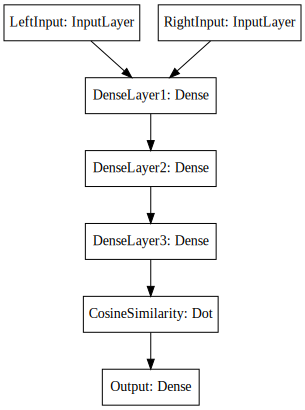

In [10]:
#plot, supervised_model = get_model(load_model=False, epochs=50, data=[X_left_train, X_right_train, Y_train])
plot, supervised_model = get_model()
plot

Layers _Input_ --> _DenseLayer3_ are used to map hotel features to embeddings. New model object is generated by copying these layers and their respective weights from the full supervised model.

Features learned in _DenseLayer3_ are used as embeddings. By mapping hotels into these embeddings we are able to compare them directly.

The requested model was not found on disk. Rebuilding the model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
LeftInput (InputLayer)       (None, 634)               0         
_________________________________________________________________
DenseLayer1 (Dense)          (None, 80)                50800     
_________________________________________________________________
DenseLayer2 (Dense)          (None, 40)                3240      
_________________________________________________________________
DenseLayer3 (Dense)          (None, 20)                820       
Total params: 54,860
Trainable params: 0
Non-trainable params: 54,860
_________________________________________________________________


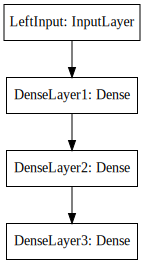

In [11]:
plot, scoring_model = get_model(model_name='Scoring Embeddings', full_model=supervised_model)
plot

### Model performance assessment
Full supervised learning model is scored to obtain cosine similarirty predictions. Correlation between original cosine similarities and predictions shows how much information was captured in embeddings. The correlation coefficient (r = 0.79, 
p < 0.01) suggests that product feature-based embeddings explain 62% of all co-purchasing behaviours.

In [12]:
pred = model_predict(supervised_model, [X_left_dev, X_right_dev])
r = pearsonr(Y_dev, pred)
print("Pearson correlation")
print('r = '+str(r[0][0].round(2))+', p = '+str(r[1][0].round(3)))

Pearson correlation
r = 0.79, p = 0.0


Embedding model is scored to assign embeddings to each hotel ID.

In [13]:
X_distinct = X_left.drop_duplicates().reset_index(drop=True)
pred = model_predict(scoring_model, [X_distinct])
hotel_embeddings = pd.concat([X_distinct['HotelID'], pred], axis=1, sort=False)

Cosine similarity is calculated based on modelled hotel embeddings and top 10 hotels by similarity are returned. The correlation coefficient between true and predicted cosine similarity is high. Selections make intuitive sense -- top recommended hotels:
* are located in European destinations
* are on the premium end of the spectrum (4* and 5* properties)
* heavily couple oriented
* mostly offer half board

In [18]:
id = '001282' # select arbitrary hotel ID
print("Target hotel")
metadata[[x for x in metadata.columns if x not in hidden]][metadata['HotelID'] == id]

Target hotel


,HotelID,HotelName,AccommodationType,Country,Destination,GP1_Derived,TRating,Latitude,Longitude,BB_AllInclusive,BB_BedAndBreakfast,BB_FullBoard,BB_HalfBoard,BB_RoomOnly,BB_SelfCatering,Party_Couple,Party_Single,Party_Family,Brand_FC,Brand_TUI,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,...,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511
22,001282,Grand President Hotel,HTL,Italy,Neapolitan Riviera,Soft Diff,5.0,40.622744,14.366899,0.0,0.0,0.0,0.997507,0.0,0.0,0.834242,0.013476,0.056551,0.0,0.999922,0.052238,0.041693,-0.002059,0.002952,-0.059918,0.022107,0.029215,0.061218,0.04116,-0.01392,-0.062725,-0.037447,-0.026675,0.010808,-0.060226,-0.015011,0.064541,0.030975,0.055923,0.064223,0.038204,-0.054942,-0.043316,-0.043804,-0.06523,-0.009394,0.000269,0.004853,-0.046792,0.04002,-0.060733,-0.040581,0.044666,0.066735,0.050476,0.04845,0.05627,0.012321,0.059783,-0.029869,0.062768,-0.066616,-0.008281,0.011398,-0.041675,-0.005364,0.024129,0.034352,-0.066756,-0.066396,0.064363,-0.012198,0.041078,0.003395,-0.023353,0.063277,-0.013714,-0.056729,0.061335,-0.064799,-0.035577,0.042208,0.046195,-0.066696,0.057351,0.063869,-0.038658,0.024767,0.033129,0.060348,-0.029238,0.009128,-0.00585,-0.044972,-0.016492,0.056721,0.060459,-0.062813,-0.025626,-0.009782,-0.05103,0.061602,-0.047266,0.001921,0.011054,0.00669,-0.063457,0.027847,-0.066621,-0.031921,0.06043,-0.028091,0.006653,-0.024263,-0.030724,-0.00728,-0.047434,-0.057279,0.007767,-0.03696,0.058416,0.005514,0.060379,0.018159,0.058074,0.053138,0.057949,0.033925,0.044561,0.058851,0.047762,0.063428,-0.050919,0.066742,-0.062005,0.059139,0.05728,-0.015364,-0.056729,-0.028842,0.027461,-0.00708,0.057566,0.053871,-0.010201,-0.056354,-0.030723,0.035715,-0.024574,-0.039538,...,-0.046121,0.058073,-0.033661,-0.004321,0.066643,0.049603,0.057307,0.065497,-0.030113,0.038263,0.062504,0.053222,0.028539,-0.049427,0.058929,-0.066114,-0.063227,-0.061592,0.020145,0.058784,-0.05124,0.06448,-0.065288,-0.050276,-0.057226,-0.059854,-0.058717,-0.028465,-0.007514,-0.065141,-0.060652,-0.065236,0.00806,0.029122,-0.000514,0.056132,-0.020275,0.057558,0.063294,-0.058854,-0.001657,0.041028,0.044858,0.010712,-0.020626,0.05674,0.04007,-0.005484,0.030177,0.047173,-0.015856,0.022659,0.046662,0.059681,-0.029703,-0.048559,-0.050229,-0.036579,0.021619,-0.064741,-0.009141,0.022127,-0.065835,-0.06208,0.021837,-0.043739,-0.019371,-0.01346,0.054235,0.066719,0.050582,-0.019113,-0.002987,-0.010705,0.062187,-0.064487,-0.057976,-0.011608,-0.012038,0.007559,0.041872,-0.033129,-0.055109,-0.021933,-0.059317,0.008695,0.047322,-0.027453,0.065496,0.003906,-0.029176,0.057186,0.042379,-0.061882,0.016405,-0.064336,0.006995,-0.006269,-0.039244,-0.030862,0.054114,-0.005423,0.030666,-0.041323,-0.053584,-0.066712,-0.001231,-0.007894,0.064467,-0.007847,0.066538,-0.044154,0.023667,-0.000832,0.011803,0.055015,0.058509,-0.021173,-0.05789,-0.045122,-0.063355,-0.065113,0.025535,-0.054485,0.055744,-0.007322,-0.051117,-0.065765,-0.02705,0.053591,0.057226,-0.04304,0.000832,0.045952,0.003627,0.035329,0.003204,-0.032369,-0.036969,-0.02491,-0.04278,0.065163,-0.02932,-0.0

In [19]:
cosine_sim = compare_embeddings(id, hotel_embeddings, cooccurrence=cooccurrence)
recs = closest_hotels(metadata, cosine_sim, n = 1000)

a, b = drop_nas([recs['Modelled_Cosine_Similarity'], recs['Cosine_Similarity']])
r = pearsonr(a, b)
print("Pearson correlation")
print('r = '+str(r[0].round(2))+', p = '+str(r[1].round(3)))

print("\nTop hotel recommendations")
recs[[x for x in recs.columns if x not in hidden]][recs['HotelID'] != id].head(10)

Pearson correlation
r = 0.91, p = 0.0

Top hotel recommendations


,HotelID,HotelName,AccommodationType,Country,Destination,GP1_Derived,TRating,Latitude,Longitude,BB_AllInclusive,BB_BedAndBreakfast,BB_FullBoard,BB_HalfBoard,BB_RoomOnly,BB_SelfCatering,Party_Couple,Party_Single,Party_Family,Brand_FC,Brand_TUI,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,...,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,Modelled_Cosine_Similarity,Cosine_Similarity
420,024249,Constantinou Bros Athena Royal Beach,HTL,Cyprus,Paphos Region,Soft Diff,4.0,34.743949,32.429379,0.121222,0.400771,0.006150,0.470502,0.00000,0.0,0.899208,0.026475,0.000834,0.000208,0.999792,-0.043053,0.049979,-0.016385,0.014204,0.042771,-0.031602,-0.018528,0.060766,-0.000232,0.018699,-0.040456,-0.004344,0.027974,0.032909,-0.054463,0.031562,0.075659,-0.059860,0.033633,0.061017,-0.033737,-0.051998,-0.053048,-0.036953,-0.010806,-0.020769,0.047815,-0.011135,-0.069862,0.055774,-0.046897,-0.044673,0.000705,0.065719,0.001754,-0.010015,0.060991,-0.042089,0.049833,-0.009478,0.054284,-0.025334,0.020921,-0.015014,-0.064350,0.019179,0.024117,0.030751,-0.078636,-0.074552,0.076451,-0.003172,0.053485,-0.005488,0.009583,0.061498,0.010027,-0.067331,0.050659,-0.077916,-0.068328,0.003403,0.009739,-0.077033,0.056805,0.021394,-0.029242,-0.052538,0.068754,0.052824,-0.021282,-0.046671,0.057019,-0.053849,-0.040994,0.007518,-0.040473,-0.059172,-0.032140,0.035455,-0.047666,0.057761,-0.045350,-0.028116,-0.055154,0.036052,-0.052364,-0.016590,-0.077173,-0.044351,0.048254,-0.021443,0.004169,-0.019518,-0.022416,-0.025775,-0.031190,-0.034714,-0.055910,-0.049920,0.013578,0.004384,0.057381,-0.005995,0.069682,0.027832,0.061390,0.026682,-0.009735,0.076778,0.041926,0.064755,-0.064075,0.078349,-0.057468,0.061141,-0.038947,-0.028497,0.034010,0.020782,-0.044285,0.039025,-0.027826,0.031128,-0.038884,-0.022218,-0.024348,0.023264,0.033777,-0.014001,...,-0.052555,0.011088,0.078489,0.039333,0.054871,0.063824,0.003535,-0.042390,0.064422,0.057852,-0.047065,-0.050390,-0.005488,-0.065754,0.045696,0.009326,-0.006574,0.072793,-0.072096,0.075890,-0.053091,0.025262,-0.003354,-0.037294,-0.069632,-0.060221,-0.073151,-0.067220,-0.058653,-0.072891,-0.025709,0.042247,-0.002196,0.029010,0.033262,0.072502,0.045256,-0.019014,0.006850,0.047123,0.031287,0.001998,0.041901,0.015027,0.011372,0.063285,0.032577,0.013239,-0.016395,0.007357,0.051795,0.060927,0.010830,-0.042004,-0.046316,-0.024431,0.006278,-0.059140,0.015508,0.025125,-0.076257,-0.029363,0.061994,0.045334,0.010336,0.026781,0.023850,0.078264,0.023727,-0.009497,0.039012,-0.027682,0.055171,-0.061364,-0.031774,-0.033982,-0.041245,0.015338,0.022846,-0.027162,-0.047992,-0.024438,-0.038592,-0.016828,0.037205,0.014896,0.064641,-0.004826,-0.007869,0.073205,-0.033107,-0.060745,0.032919,-0.062173,-0.025712,-0.050962,-0.002167,-0.011975,0.022826,0.064549,0.070138,-0.005931,-0.038599,-0.076673,-0.022045,-0.017127,0.064194,-0.030831,0.068844,-0.020272,0.023460,0.046830,0.007476,0.022533,0.040980,-0.027971,-0.059894,-0.054891,-0.045892,-0.016113,-0.014435,-0.029351,0.051557,0.004031,-0.020833,-0.059185,-0.021768,0.050569,0.046909,-0.027964,0.024000,0.043082,0.059453,

When hotels are plotted in 2D space using [t-SNE algorithm](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html), it becomes obvious how neural network prioritises certain features over others based on how useful they are for similarity detection. For instance, hotels clearly cluster by average holiday cost, meaning that hotels in similar price range tend to be booked by the same people. At the same time, internal classification of hotels (_GP1_Derived_) which groups hotels by their level of exclusivity (TUI own hotel concepts vs generic hotels shared with other tour operators) has little relationship with how hotels are grouped.

In [20]:
tsne = get_tsne(hotel_embeddings, metadata)

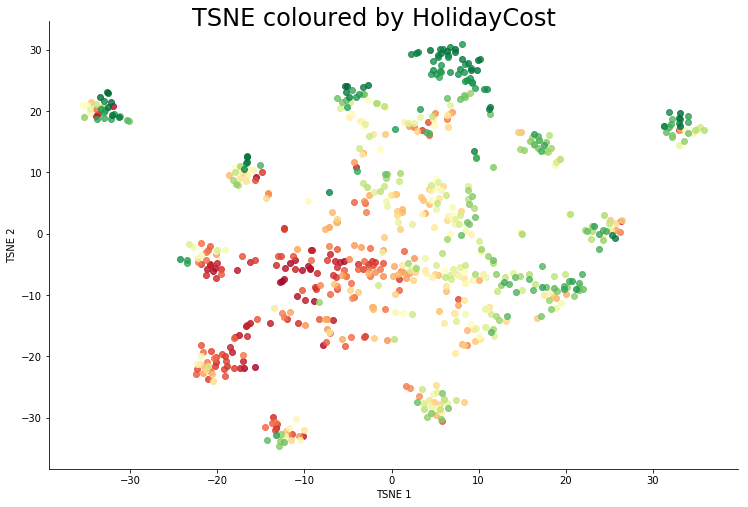

In [22]:
plot_tsne(tsne, 'HolidayCost', categorical)

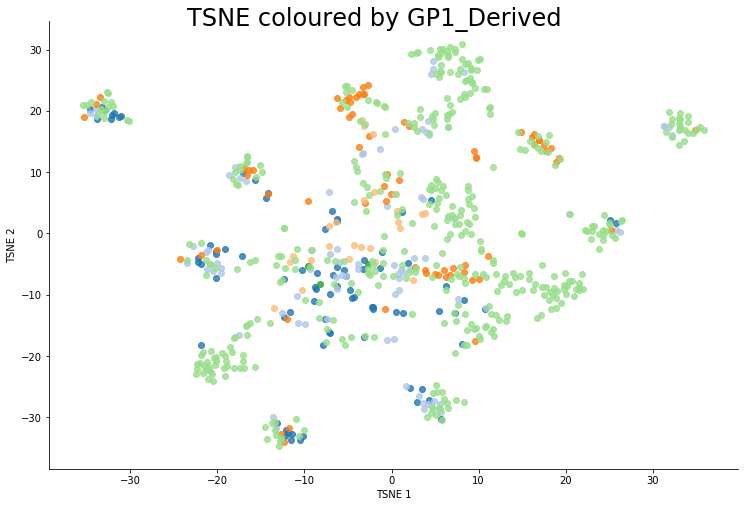

In [25]:
plot_tsne(tsne, 'GP1_Derived', categorical)

## Future directions
As a next step, I am planning to build a supervised model that maps customer features (e.g., demographic characteristics) and past behaviour to the set of hotel embeddings in order to build a customer-level recommendation model. Multiple historical hotel choices can be taken into account using a recurrent neural network architecture. A set of hotels that were last booked by customers (mapped to corresponding embeddings) will be used as labels.

Based on this approach, it will be possible to calculate prediction accuracy of this recommender algorithm.